<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Neural_Network/blob/main/Adversarial_Diffusion_Distillation_Last_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cose da fare

L'obbiettivo di tutto il modello è quello di rendere l'ADD student il più bravo possibile  ma con un numero molto piccolo di istanti in cui viene fatto il denoising.
Utilizziamo quindi lo stesso modello per il teacher  e poer lo student ma allo student diamo solo da 1 a 4 istanti di denoising e lo aggiorniamo con la loss in modo che impari a predire le immagini giuste nel minor tempo possibile

*   Importare il dataset e preprocessing
*   Realizzare il Discriminator(ViT) e pretrainarlo da zero e salvarne i weights, importarne i weights e visto ceh le performance saranno scarse prova ad utilizzare un vit_b_16 pretrainato
*   Realizzare il forward process che aggiunge il noise all'immagine
*   Realizzare il denoise process (ADD-Student) che toglie il rumore dell'immagine e genera la nuova immagine
*   Calcolare la Discriminator Loss (condizionarla all'immagine iniziale utilizzando un dino model)
*   Riaggiungere il rumore all'immagine generata dallo Student
*   Utilizzare il DM-Teacher per ricostruire una nuova immagine(ricordati che non deve essere trainato)
*   Calcolare la distillation Loss
##RISOLVERE I PROBLEMI


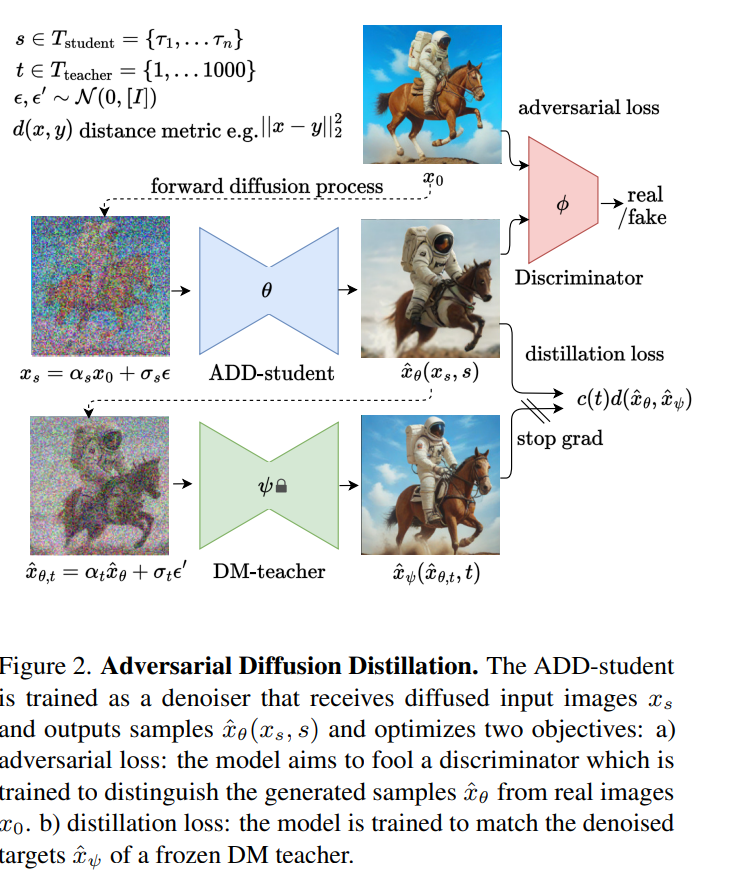









https://static1.squarespace.com/static/6213c340453c3f502425776e/t/65663480a92fba51d0e1023f/1701197769659/adversarial_diffusion_distillation.pdf

https://arxiv.org/pdf/2006.11239.pdf


#Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U einops datasets matplotlib tqdm

import math
import torch as torch
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import einsum
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
from torchvision import datasets
from torch.optim import Adam

BATCH_SIZE=64

device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 516.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
transform = tt.Compose([
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.Lambda(lambda t: (t * 2) - 1)
])

dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

print(dataset)
# create dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 10186235.81it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200535.35it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3795885.17it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17427180.78it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )


In [4]:
def show_batch(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(24, 24))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:16][0], nrow=8).permute(1, 2, 0))
        break

torch.Size([64, 1, 28, 28])


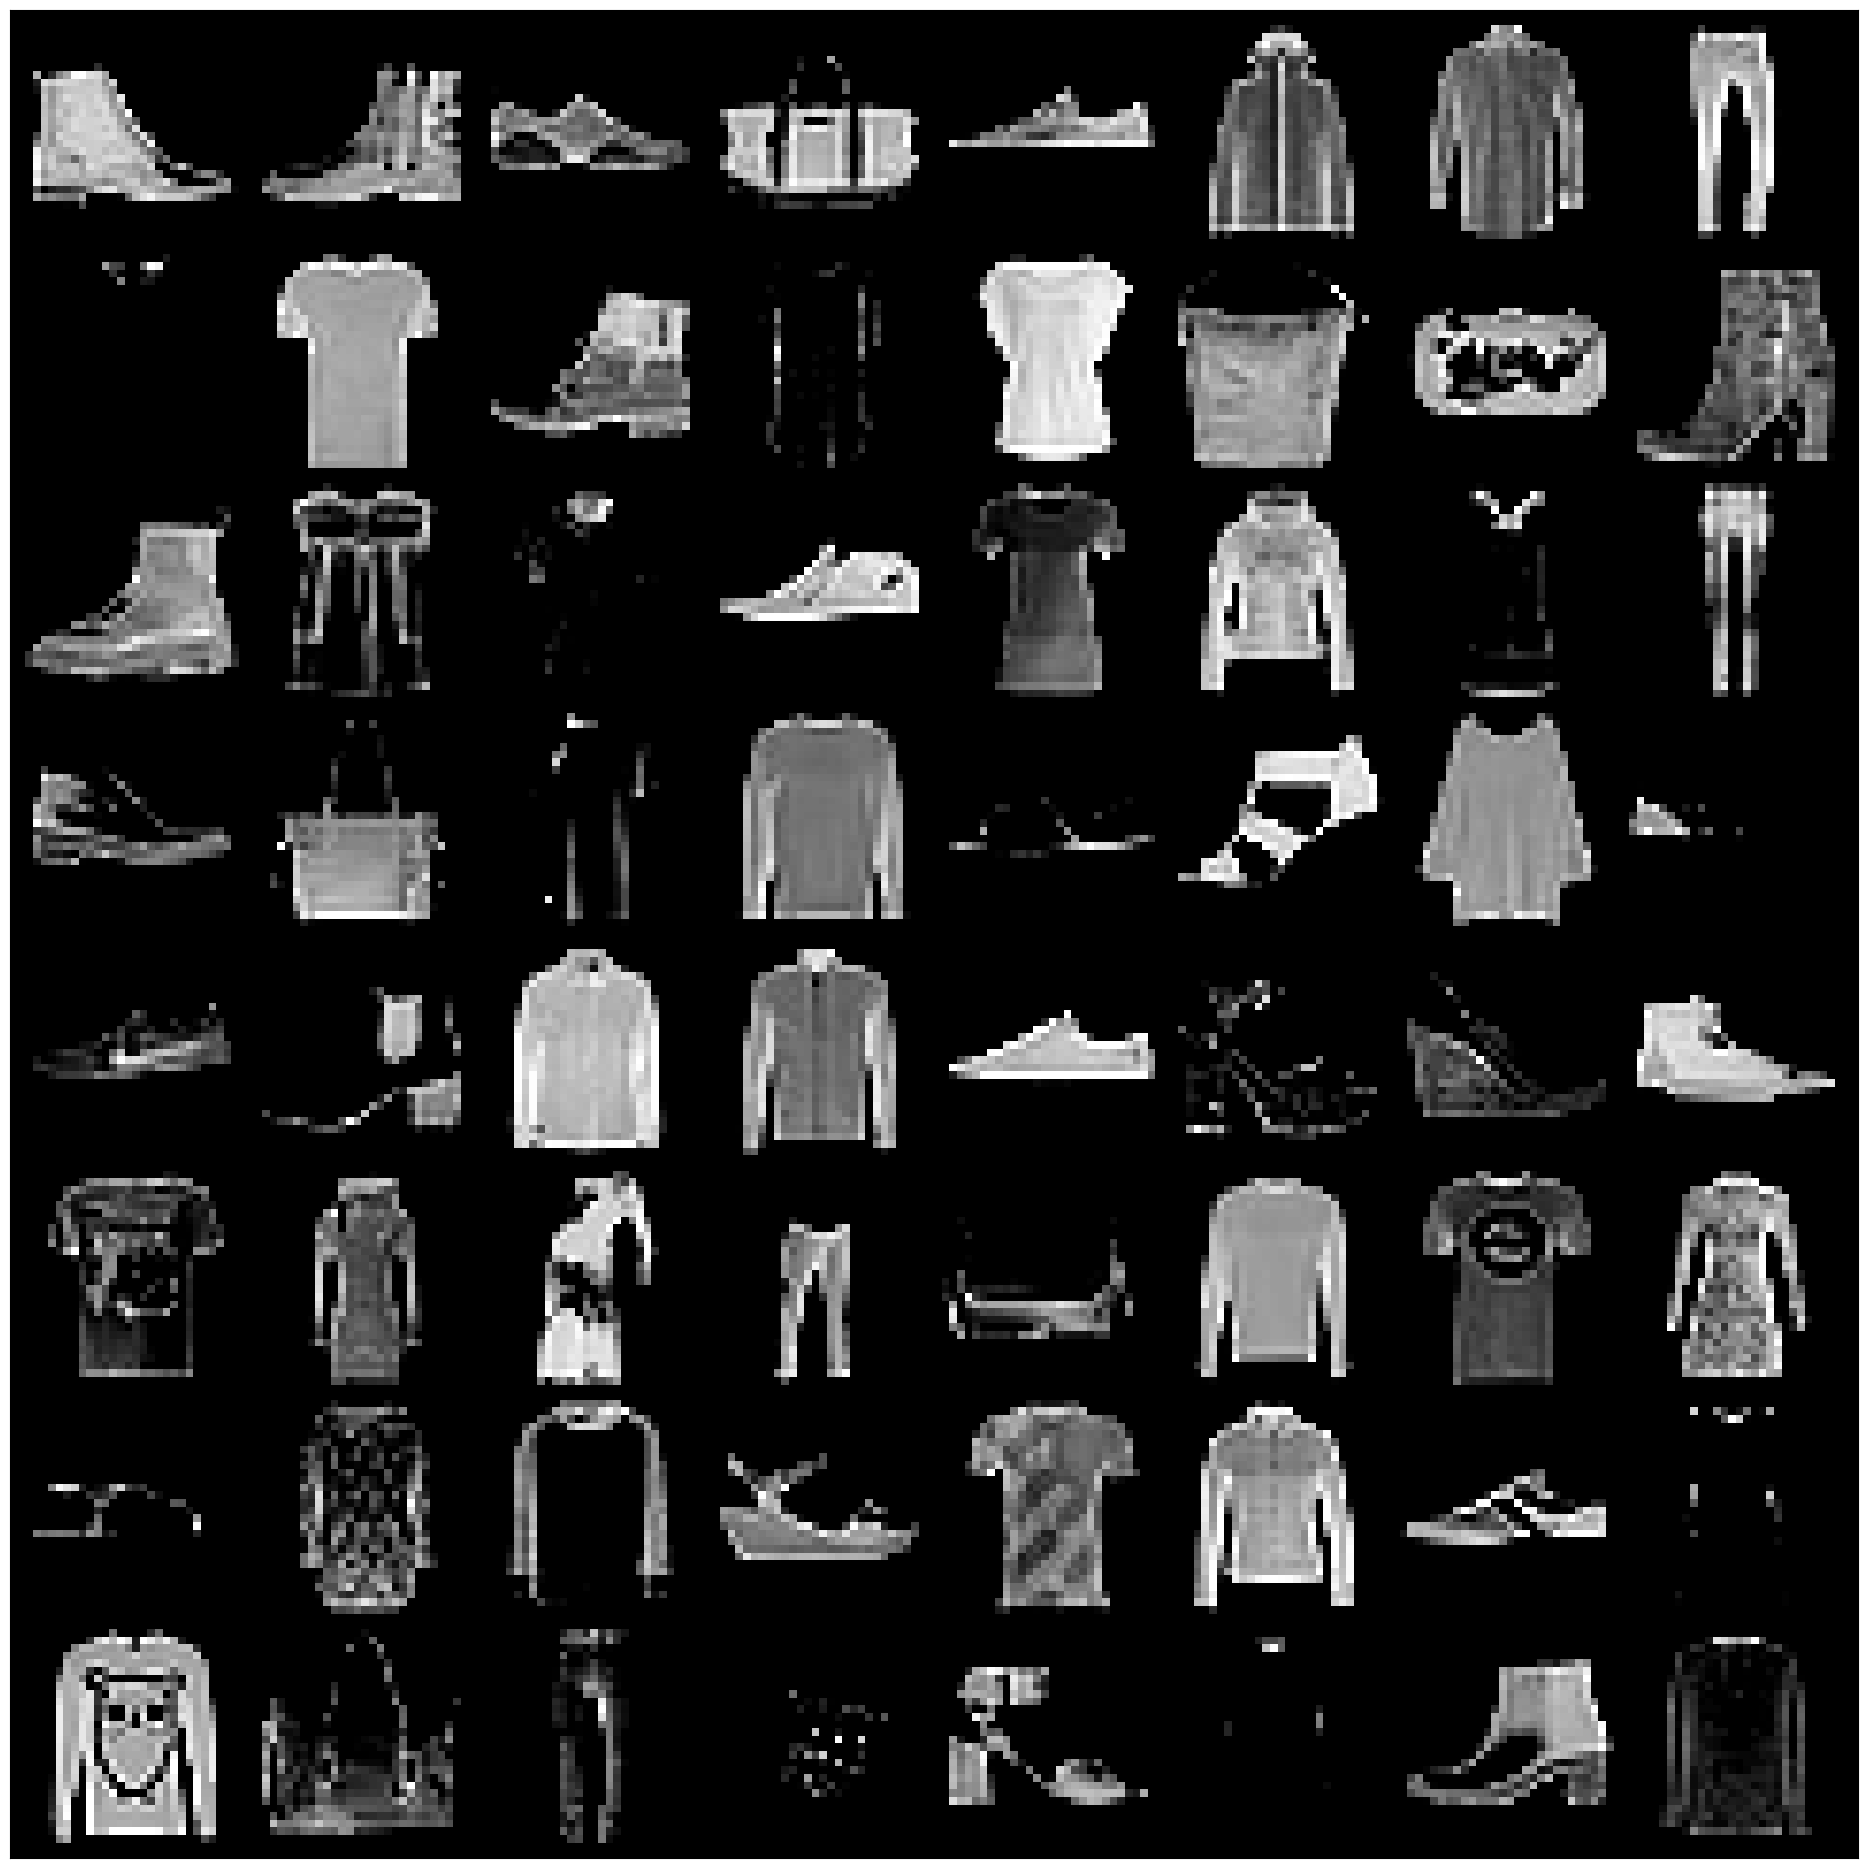

In [5]:
show_batch(dataloader)

In [6]:
#time schedule
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

timesteps = 1000

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. -  betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [7]:
IMG_SIZE = 28

def show_tensor_image(image):
    reverse_transforms = tt.Compose([
        tt.Lambda(lambda t: (t + 1) / 2),
        tt.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        tt.Lambda(lambda t: t * 255.),
        tt.Lambda(lambda t: t.numpy().astype(np.uint8)),
        tt.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


torch.Size([64, 1, 28, 28])


<ipython-input-8-f27da4a9ee29>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


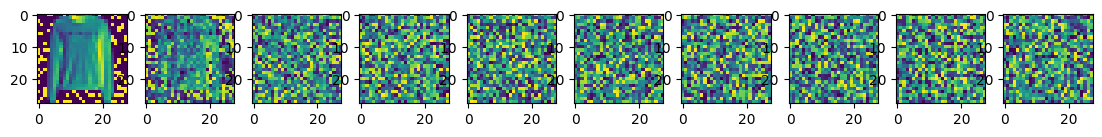

In [8]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
print(image.shape)

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(1, timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = q_sample(image, t)
    show_tensor_image(img)

# UNet

La UNet viene utilizzata per fare in modo che il modello impari solo le parti più importanti dell'immagini tralasciando i dettagli



##UNeT

In [9]:
#Utilities

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) #concatenazione
        return embeddings

In [11]:
class UNet_Block(nn.Module):
  def __init__(self, dim_input, dim_output, groups=4):
    super().__init__()
    self.proj = nn.Conv2d(dim_input, dim_output, 3, padding = 1)
    self.normalization= nn.GroupNorm( groups, dim_output)
    self.act= nn.SiLU()

  def forward(self, x):
    x = self.proj(x)
    x = self.normalization(x)
    x = self.act(x)

    return x

class UNet_ResNet(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=4):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = UNet_Block(dim, dim_out, groups=groups)
        self.block2 = UNet_Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.num_heads = num_heads
        hidden_dim = dim_head * num_heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.num_heads), qkv
        )
        #batch, num_heads, dim_features, x, y
        #organizza le informazioni ottenute dalla proiezione lineare in q, k, e v nel formato appropriato
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k) #specifica come fare la moltiplicazione tra il vettore q (batch, num_heads, dim_features, index(i)) e k(batch, num_heads, dim_features, index(j))
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [13]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=1,#rgb
        with_time_emb=True,
        resnet_block_groups=4,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] #dim * [1,2,4,8]
        in_out = list(zip(dims[:-1], dims[1:]))  #dim * [1,2,4,8,4,2,1]

        block_klass = partial(UNet_ResNet, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),


                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )


    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

##Train Teacher

In [14]:
# load dataset from the hub
image_size = 28
channels = 1
batch_size = 64

device = "cuda" if torch.cuda.is_available() else "cpu"

diffusion_model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
diffusion_model.to(device)


Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): UNet_ResNet(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): UNet_Block(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): UNet_Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride

In [ ]:
from torchvision.utils import save_image
from pathlib import Path

epochs = 10

optimizer = Adam(diffusion_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      #genera sample e calcola loss

      noise=torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy = q_sample(x_start=batch, t=t, noise=noise)
      predicted_noise = diffusion_model(x_noisy[0], t)

      loss = F.smooth_l1_loss(noise, predicted_noise)

      if step % 200 == 0:
        print("Epoch: " + str(epoch)+ "   Loss:", loss.item())

      loss.backward()
      optimizer.step()

    scheduler.step(loss)

Epoch: 0   Loss: 0.47956427931785583
Epoch: 0   Loss: 0.03963305801153183
Epoch: 0   Loss: 0.03146519884467125
Epoch: 0   Loss: 0.026779232546687126
Epoch: 0   Loss: 0.023648502305150032
Epoch: 1   Loss: 0.027252690866589546
Epoch: 1   Loss: 0.017748219892382622
Epoch: 1   Loss: 0.02674570493400097
Epoch: 1   Loss: 0.028866605833172798
Epoch: 1   Loss: 0.01821730099618435
Epoch: 2   Loss: 0.01732209511101246
Epoch: 2   Loss: 0.01871790923178196
Epoch: 2   Loss: 0.024630950763821602
Epoch: 2   Loss: 0.019228126853704453
Epoch: 2   Loss: 0.0313754677772522
Epoch: 3   Loss: 0.02388240583240986
Epoch: 3   Loss: 0.018747402355074883
Epoch: 3   Loss: 0.02249843254685402
Epoch: 3   Loss: 0.01280226744711399
Epoch: 3   Loss: 0.023135963827371597
Epoch: 4   Loss: 0.018378084525465965
Epoch: 4   Loss: 0.02416257932782173
Epoch: 4   Loss: 0.018577760085463524
Epoch: 4   Loss: 0.016085762530565262
Epoch: 4   Loss: 0.01658417284488678
Epoch: 5   Loss: 0.018839767202734947
Epoch: 5   Loss: 0.0322440

In [ ]:
path = '/content/drive/MyDrive/diffusion_model.pth'

# Salva il modello
torch.save(diffusion_model.state_dict(), path)

##Train Student

In [15]:
# load dataset from the hub
image_size = 28
channels = 1
batch_size = 64

device = "cuda" if torch.cuda.is_available() else "cpu"

student_model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
student_model.to(device)

Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): UNet_ResNet(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): UNet_Block(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): UNet_Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride

In [42]:
from torchvision.utils import save_image
from pathlib import Path

epochs = 30
timesteps =10

optimizer = Adam(diffusion_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      #genera sample e calcola loss

      noise=torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy = q_sample(x_start=batch, t=t, noise=noise)
      predicted_noise = diffusion_model(x_noisy[0], t)

      loss = F.smooth_l1_loss(noise, predicted_noise)

      if step % 200 == 0:
        print("Epoch: " + str(epoch)+ "   Loss:", loss.item())

      loss.backward()
      optimizer.step()

    scheduler.step(loss)

Epoch: 0   Loss: 0.15360023081302643
Epoch: 0   Loss: 0.16659612953662872
Epoch: 0   Loss: 0.17688466608524323
Epoch: 0   Loss: 0.16404350101947784
Epoch: 0   Loss: 0.16767536103725433
Epoch: 1   Loss: 0.16065438091754913
Epoch: 1   Loss: 0.17156024277210236
Epoch: 1   Loss: 0.17551861703395844
Epoch: 1   Loss: 0.15901310741901398
Epoch: 1   Loss: 0.17140726745128632
Epoch: 2   Loss: 0.16920167207717896
Epoch: 2   Loss: 0.15369421243667603
Epoch: 2   Loss: 0.16198258101940155
Epoch: 2   Loss: 0.17798225581645966
Epoch: 2   Loss: 0.1765872836112976
Epoch: 3   Loss: 0.1795719712972641
Epoch: 3   Loss: 0.1675163209438324
Epoch: 3   Loss: 0.16818423569202423
Epoch: 3   Loss: 0.16499418020248413
Epoch: 3   Loss: 0.17609241604804993
Epoch: 4   Loss: 0.16390840709209442
Epoch: 4   Loss: 0.16292065382003784
Epoch: 4   Loss: 0.1719186156988144
Epoch: 4   Loss: 0.17158262431621552
Epoch: 4   Loss: 0.1603725701570511
Epoch: 5   Loss: 0.17497655749320984
Epoch: 5   Loss: 0.1565725952386856
Epoch: 

KeyboardInterrupt: 

In [43]:
path = '/content/drive/MyDrive/student_model.pth'

# Salva il modello
torch.save(student_model.state_dict(), path)

##Generate new samples

In [14]:
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
def p_sample_loop(model,img, shape, timesteps):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    #img = torch.randn(shape, device=device)
    imgs = []

    for i in reversed(range(0, timesteps)):   #tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

def sample(model, img, image_size, timestep, batch_size=BATCH_SIZE, channels=1):
    return p_sample_loop(model, img,  shape=(batch_size, channels, image_size, image_size), timesteps=timestep)

In [45]:
with torch.no_grad():
  t = torch.rand([64,1,28,28])
  sample_data = sample(student_model, t.to(device), image_size=image_size, timestep=10,  batch_size=BATCH_SIZE, channels=1)

3


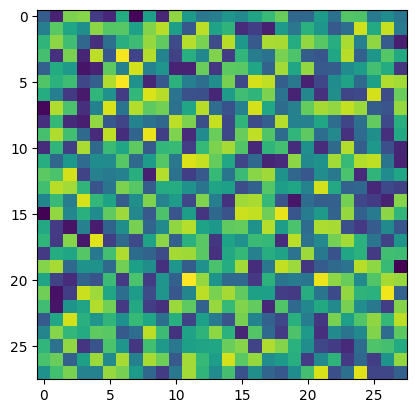

In [46]:
# show a random one
random_index = random.randint(0, 63)
print(random_index)

image_data = sample_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

# Normalizza i dati dell'immagine nel range [0, 1] se sono float
image_data_normalized = image_data / np.max(image_data)

# Visualizza l'immagine normalizzata
plt.imshow(image_data_normalized)
plt.show()

# Discriminator

##ViT

In [15]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
from einops import repeat


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size,  emb_size = 64):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        )
        self.linear= nn.Linear(patch_size * patch_size * in_channels, emb_size).to(device)

    def forward(self, x):
        x = self.projection(x)
        x = self.linear(x) #abbiamo le patches
        return x


In [16]:
class DiscResidual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class DiscPreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


In [17]:
class DiscAttention(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super(DiscAttention, self).__init__()
    self.emb_dim=emb_dim
    self.num_heads = num_heads

    self.attention = nn.MultiheadAttention(self.emb_dim, self.num_heads, dropout=0.1)

    self.q = nn.Linear(emb_dim, emb_dim)
    self.k = nn.Linear(emb_dim, emb_dim)
    self.v = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention, attention_weights = self.attention(q, k, v)
    return attention

In [18]:
class ViT(nn.Module):
  def __init__(self, emb_dim, hidden_dim, out_dim, channels, input_channels=1, patch_size = 7,  n_layers = 3,  img_size=28, dropout=0.1, num_heads = 8):
    super(ViT, self).__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.dropout = dropout
    self.channels = channels
    self.img_width = img_size
    self.img_height = img_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(channels, patch_size= patch_size,  emb_size = emb_dim)

    #self.patch_extraction = PatchExtractionBlock(input_channels, output_channels)

    # Learnable params
    num_patches = (img_size // patch_size) ** 2
    self.positional_emb = nn.Parameter(torch.randn(emb_dim, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

    self.layers = nn.ModuleList([])
    for _ in range(n_layers):
      block = nn.Sequential(

          DiscResidual(DiscPreNorm(emb_dim, DiscAttention(emb_dim, num_heads))),

          DiscResidual(DiscPreNorm(emb_dim, nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                                  nn.LeakyReLU(),
                                                  nn.Dropout(dropout),
                                                  nn.Linear(hidden_dim, emb_dim),
                                                  nn.Dropout(dropout)
                                              )))
      )
      self.layers.append(block)

    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim* (num_patches + 1)), nn.Linear(emb_dim* (num_patches + 1), out_dim))
    self.sigmoid = nn.Sigmoid()
    self.projection = nn.Sequential(
            Rearrange('b h p -> b (h p)')
        )

  def forward(self, batch):
      #images = self.patch_extraction(images)
      x = self.patch_embedding(batch)
      b, n, _ = x.shape

      # Add cls token to inputs
      cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
      x = torch.cat([cls_tokens, x], dim=1)
      x += self.positional_emb[:, :(n+1),:]
      for layer in self.layers:
        x = layer(x)
      x = self.projection(x)
      return self.sigmoid(self.classification_head(x[:, :]))

losses = []
discriminator_model = ViT(64, 512, 1, 1).to(device)

##Training

In [ ]:
num_epochs=1
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=1e-4)

for epoch in range(num_epochs):

    for step, batch in enumerate(dataloader):

        if step ==10:
          break

        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (batch[0].shape[0],), device=device).long().to(device)

        noise=torch.randn_like(batch[0]).to(device) #crea rumore con la stessa dimensione del batch
        x_noisy = q_sample(x_start=batch[0].to(device), t=t, noise=noise)
        predicted_noise = diffusion_model(x_noisy[0], t)
        with torch.no_grad():
          fake_data = sample( diffusion_model, x_noisy[0], image_size, timestep=timesteps,  batch_size=BATCH_SIZE, channels=channels)

        # Preparazione dei dati
        real_data = batch

        # Etichette per esempi reali e falsi
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        if real_data[0].shape[0] == BATCH_SIZE:
          output_real = discriminator_model(real_data[0].to(device))
          loss_real = criterion(output_real, real_labels)
        else:
          break

        # Forward pass per esempi falsi
        output_fake = discriminator_model(fake_data[-1].detach())  # Detach per evitare di propagare il gradiente al generatore
        loss_fake = criterion(output_fake, fake_labels)

        # Calcolo totale della loss
        total_loss = loss_real + loss_fake
        #if step % 100 == 0:
        print(loss_real)
        print(loss_fake)
        print("Epoch: " + str(epoch)+ "   Loss:", total_loss)

        total_loss.backward()
        optimizer.step()

tensor(0.6420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4868, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7713, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4557, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4405, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7584, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>

In [ ]:
path = '/content/drive/MyDrive/discriminator_model.pth'

# Salva il modello
torch.save(discriminator_model.state_dict(), path)

# Full Train

In [19]:
image_size = 28
channels = 1
batch_size = 64
student_timesteps = 10
teacher_timesteps= 1000

In [20]:
# Specifica il percorso nel tuo Google Drive dove hai salvato il modello
diffusion_path = '/content/drive/MyDrive/diffusion_model.pth'
discriminator_path = '/content/drive/MyDrive/discriminator_model.pth'
student_path = '/content/drive/MyDrive/student_model.pth'


# Carica il teacher_model
teacher_model = Unet(    dim=image_size,    channels=channels,    dim_mults=(1, 2, 4,))
teacher_model.load_state_dict(torch.load(diffusion_path))
teacher_model.eval()
teacher_model.to(device)

# Carica il discriminator_model
discriminator_model = ViT(64, 512, 1, 1)
discriminator_model.load_state_dict(torch.load(discriminator_path))
discriminator_model.train()
discriminator_model.to(device)

# Carica il teacher_model
student_model = Unet( dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
student_model.load_state_dict(torch.load(diffusion_path))
student_model.train()
student_model.to(device)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Hai trainato prima lo student confrontandolo con il batch e non con il teacher

Poi hai sostituito il batch al teacher e hai trainato con un basso livello di rumore in input in modo che il teacher avesse una vaga idea dell'immagine iniziale

Poi hai alzato il livello di rumore per fare in modo che lo student impari a predire partendo da un alto livello di rumore(devi migliorare il teacher)

In [ ]:
torch.cuda.empty_cache()
epochs = 20
disc_loss = nn.BCELoss()
disc_loss2 = nn.BCELoss()
dis_loss = nn.SmoothL1Loss()
l = 2.5

student_optimizer = Adam(student_model.parameters(), lr=1e-3)#, weight_decay=1e-5)
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-3)#, weight_decay=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=1, factor=0.1)
scheduler_discriminator = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=1, factor=0.1)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()
      random_index = random.randint(0, 63)

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(0, 299, (batch_size,), device=device).long()
      t_teacher = t_student #torch.randint(0, 399, (batch_size,), device=device).long()#batch_size

      noise = torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      #SHOW THE ORIGINAL IMAGE
      image_data0 = batch[random_index].cpu().numpy().reshape(image_size, image_size, channels)

      #predicted_noise = student_model(x_noisy_student[0], t_student)

      student_data = sample( student_model, x_noisy_student[0], image_size, timestep=student_timesteps,  batch_size=BATCH_SIZE, channels=channels)

      #SHOW STUDENT RESULT

      image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)

      # Etichette per esempi reali e falsi
      real_labels = torch.ones(BATCH_SIZE, 1).to(device)
      fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

      output_real = discriminator_model(batch)
      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1])  # Detach per evitare di propagare il gradiente al generatore
      loss_fake = disc_loss(output_fake, fake_labels)

      if step%2==0:
        # Calcolo totale della loss
        adversarial_loss = loss_real + loss_fake
        adversarial_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      #noise=torch.randn_like(batch)

      x_noisy_teacher = q_sample(x_start=x_noisy_student[0], t=t_teacher, noise=noise)
      image_data2 = x_noisy_teacher[0][random_index].cpu().numpy().reshape(image_size, image_size, channels)

      with torch.no_grad():

        #teacher_predicted_noise = teacher_model(x_noisy_teacher[0], t_teacher)
        teacher_data = sample( teacher_model, student_data[-1], image_size, timestep=teacher_timesteps,  batch_size=BATCH_SIZE, channels=channels)

      #SHOW TEACHER RESULT

      image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

      plt.imshow(image_data0)
      plt.show()
      plt.imshow(image_data1)
      plt.show()
      plt.imshow(image_data3)
      plt.show()

      distill_loss = dis_loss(student_data[-1], teacher_data[-1].requires_grad_())

      loss = l*distill_loss + loss_fake
      losses.append(loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)
    scheduler_discriminator.step(adversarial_loss)

In [27]:
discriminator_path = '/content/drive/MyDrive/discriminator_model.pth'
student_path = '/content/drive/MyDrive/student_model.pth'

# Salva il modello
torch.save(discriminator_model.state_dict(), discriminator_path)
torch.save(student_model.state_dict(), student_path)

In [ ]:
t_teacher = torch.rand([64,1,28,28])
with torch.no_grad():
  teacher_data = sample(teacher_model, t_teacher.to(device), image_size=image_size, timestep=500,  batch_size=BATCH_SIZE, channels=channels)

In [ ]:
# show a random one
random_index = random.randint(0, 63)
print(random_index)

image_data = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

plt.imshow(image_data)
plt.show()

In [38]:
t_student = next(iter(dataloader))
t = torch.randint(200, 400, (128,), device=device).long()
noise=torch.randn_like(t_student[0])
with torch.no_grad():
  x_noisy_student = torch.rand([64,1,28,28]).to(device) #q_sample(x_start=t_student[0].to(device), t=t.to(device), noise=noise.to(device))
  student_data = sample(student_model, x_noisy_student, image_size=image_size, timestep=10,  batch_size=BATCH_SIZE, channels=channels)

8


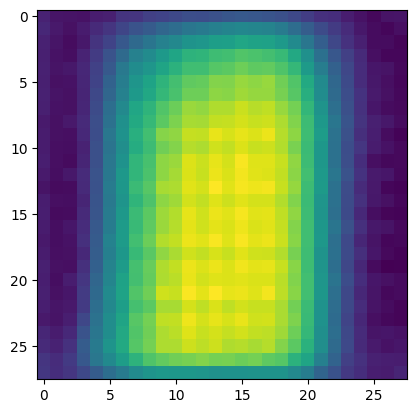

In [42]:
# show a random one
random_index = random.randint(0, 64)
print(random_index)

# Normalizza i dati dell'immagine nel range [0, 1] se sono float

image_data = student_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

plt.imshow(image_data)
plt.show()
#print(len(samples[-1]))#samples = [200,128,1,28,28]